In [459]:
from PIL import Image
import torch
import os
import numpy as np
import pickle
from utils.utils import *
from utils.file_utils import save_pkl, load_pkl
from models.resnet_custom import resnet50_baseline
from models.model_clam import CLAM_MB, CLAM_SB
from torch.utils.data import DataLoader
from scipy.stats import percentileofscore
import matplotlib.pyplot as plt

In [460]:
drop_out = False
n_classes = 2
model_type = "clam_sb"
model_size = 'small'
exp_code = "exp_6" + "_s1"
ckpt_path = "s_0_checkpoint.pt"
results_dir = "image_sets/results"

data_dir = "image_sets/original/"
image_ext = ".tif"
patch_dir = "image_sets/patches/"
feat_dir = "image_sets/features/"
actual_feat_dir = "image_sets/patches/fungal_vs_nonfungal_resnet_features/pt_files/"

save_path = os.path.join(results_dir, exp_code, "heatmaps")
if not os.path.isdir(save_path):
    os.mkdir(save_path)

In [461]:
# ---------------------------
# Heatmap Image options
patch_size = (256, 256) # patch_size (tuple of int)
binarize = False
overlap = 0
blur = 0
alpha = 1.0
cmap='coolwarm'
thresh = -1
# ---------------------------

In [462]:
heatmap_dict = load_pkl(os.path.join(results_dir, exp_code, "heatmap_dict.pkl"))

In [463]:
image_file = heatmap_dict[0]

image_name = image_file['filename']
attention_scores = image_file['attention_scores']
coords_list = image_file['coords_list']

In [464]:
if isinstance(cmap, str):
    cmap = plt.get_cmap(cmap)

img = np.array(Image.open(os.path.join(data_dir, image_name+image_ext)))
img = img[0:1024, 0:1536] # No left-overs

In [465]:
ref = attention_scores.copy()
scores = []
for score in attention_scores:
    score = percentileofscore(ref, score)
    scores.append(score/100)
# print(attention_scores)
# print()
# print(scores)

In [466]:
if binarize:
    if thresh < 0:
        threshold = 1.0/len(scores)
    else:
        threshold =  thresh
else:
    threshold = 0.0
# print(threshold)

In [467]:
# region_size = (1600, 1200)
region_size = (1536, 1024)
overlay = np.full(np.flip(region_size), 0).astype(float)
counter = np.full(np.flip(region_size), 0).astype(np.uint16)      
count = 0

In [468]:
for index, score in enumerate(scores):
    coord = coords_list[index]
    coord = [256*x for x in coord]
#         print("coord", coord)
    if score >= threshold:
        if binarize:
            score=1.0
            count+=1
    else:
        score=0.0
#     print(coord[1], coord[1]+patch_size[1], coord[0], coord[0]+patch_size[0])
    print("(", coord[0], ",", coord[1], ") to (" , coord[0]+patch_size[0], ",", coord[1]+patch_size[1], ")")
    # accumulate attention
    overlay[coord[1]:coord[1]+patch_size[1], coord[0]:coord[0]+patch_size[0]] += score
    # accumulate counter
    counter[coord[1]:coord[1]+patch_size[1], coord[0]:coord[0]+patch_size[0]] += 1
print(len(np.where(overlay == 0)[0]))

( 0 , 0 ) to ( 256 , 256 )
( 0 , 256 ) to ( 256 , 512 )
( 0 , 512 ) to ( 256 , 768 )
( 0 , 768 ) to ( 256 , 1024 )
( 0 , 1024 ) to ( 256 , 1280 )
( 0 , 1280 ) to ( 256 , 1536 )
( 256 , 0 ) to ( 512 , 256 )
( 256 , 256 ) to ( 512 , 512 )
( 256 , 512 ) to ( 512 , 768 )
( 256 , 768 ) to ( 512 , 1024 )
( 256 , 1024 ) to ( 512 , 1280 )
( 256 , 1280 ) to ( 512 , 1536 )
( 512 , 0 ) to ( 768 , 256 )
( 512 , 256 ) to ( 768 , 512 )
( 512 , 512 ) to ( 768 , 768 )
( 512 , 768 ) to ( 768 , 1024 )
( 512 , 1024 ) to ( 768 , 1280 )
( 512 , 1280 ) to ( 768 , 1536 )
( 768 , 0 ) to ( 1024 , 256 )
( 768 , 256 ) to ( 1024 , 512 )
( 768 , 512 ) to ( 1024 , 768 )
( 768 , 768 ) to ( 1024 , 1024 )
( 768 , 1024 ) to ( 1024 , 1280 )
( 768 , 1280 ) to ( 1024 , 1536 )
524288


In [469]:
# # fetch attended region and average accumulated attention
# zero_mask = counter == 0
# # zero_mask is 1 for left-over strips

# if binarize:
#     overlay[~zero_mask] = np.around(overlay[~zero_mask] / counter[~zero_mask])
# else:
#     overlay[~zero_mask] = overlay[~zero_mask] / counter[~zero_mask]
#     # overlay[~zero_mask] is empty for left-over strips, else not.
# del counter 

0.16666666666666669 [0, 0]
[[0.16666667 0.16666667 0.16666667 ... 0.16666667 0.16666667 0.16666667]
 [0.16666667 0.16666667 0.16666667 ... 0.16666667 0.16666667 0.16666667]
 [0.16666667 0.16666667 0.16666667 ... 0.16666667 0.16666667 0.16666667]
 ...
 [0.16666667 0.16666667 0.16666667 ... 0.16666667 0.16666667 0.16666667]
 [0.16666667 0.16666667 0.16666667 ... 0.16666667 0.16666667 0.16666667]
 [0.16666667 0.16666667 0.16666667 ... 0.16666667 0.16666667 0.16666667]]
[[[111 145 242]
  [111 145 242]
  [111 145 242]
  ...
  [111 145 242]
  [111 145 242]
  [111 145 242]]

 [[111 145 242]
  [111 145 242]
  [111 145 242]
  ...
  [111 145 242]
  [111 145 242]
  [111 145 242]]

 [[111 145 242]
  [111 145 242]
  [111 145 242]
  ...
  [111 145 242]
  [111 145 242]
  [111 145 242]]

 ...

 [[111 145 242]
  [111 145 242]
  [111 145 242]
  ...
  [111 145 242]
  [111 145 242]
  [111 145 242]]

 [[111 145 242]
  [111 145 242]
  [111 145 242]
  ...
  [111 145 242]
  [111 145 242]
  [111 145 242]]

 [[

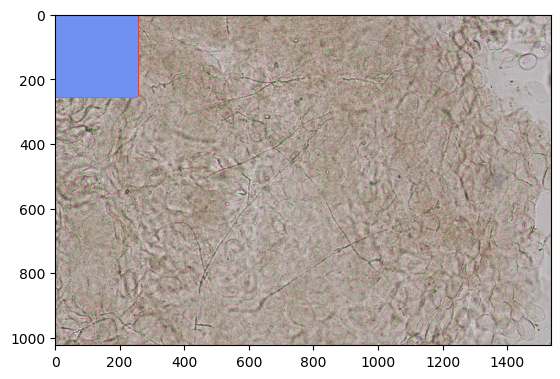

In [470]:
for index, score in enumerate(scores):
    coord = coords_list[index]
    print(score, coord)
    
    if score >= threshold:

        # attention block
        raw_block = overlay[coord[1]:coord[1]+patch_size[1], coord[0]:coord[0]+patch_size[0]]
        
        print(raw_block)

        # image block (either blank canvas or orig image)
        img_block = img[coord[1]:coord[1]+patch_size[1], coord[0]:coord[0]+patch_size[0]].copy()

        # color block (cmap applied to attention block)
        color_block = (cmap(raw_block) * 255)[:,:,:3].astype(np.uint8)

        # copy over entire color block
        img_block = color_block
        print(color_block)

        # rewrite image block
        img[coord[1]:coord[1]+patch_size[1], coord[0]:coord[0]+patch_size[0]] = img_block.copy()
plt.imshow(img)

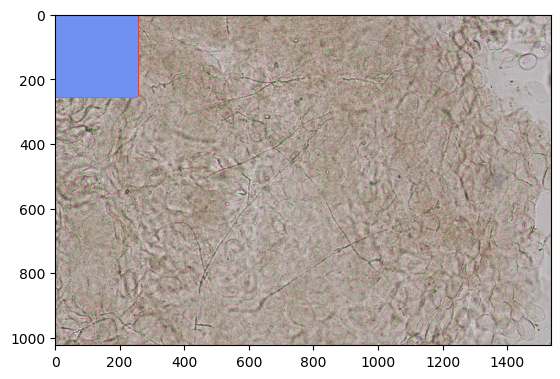

In [471]:
if blur:
    img = cv2.GaussianBlur(img,tuple((patch_size * (1-overlap)).astype(int) * 2 +1),0)  

if alpha < 1.0:
    img = self.block_blending(img, vis_level, top_left, bot_right, alpha=alpha, blank_canvas=blank_canvas, block_size=1024)

img = Image.fromarray(img)

plt.imshow(img)